In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Thiết lập seed để kết quả tái lập được
np.random.seed(42)
tf.random.set_seed(42)

# Thiết lập các tham số
input_steps = 6   # Số giờ làm đầu vào
output_steps = 6  # Số giờ dự báo sau


In [3]:
import pandas as pd
data_file = "data_readed.xlsx"
df = pd.read_excel(data_file)
df.head()


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0,104,2020-10-01 00:00:00,0.0,197.25,61.953484,-113.054688,-0.000017,0.676296,36.621414,...,-59037,0.023543,-27549,0.373413,59.393524,59.004852,-5.800369,-0.907883,-0.157303,3.689789
1,0,104,2020-10-01 01:00:00,0.0,138.50,9999.000000,-128.285156,-0.000038,0.676296,36.078514,...,-203202,0.023543,-64968,0.274780,59.516571,59.215790,-5.511688,-0.485977,-0.572311,3.517319
2,0,104,2020-10-01 02:00:00,0.0,102.00,9999.000000,-120.671875,-0.000055,0.676296,35.410492,...,-376145,0.023543,-81566,0.194763,59.715759,59.483337,-4.963364,-0.448380,-1.284912,3.182495
3,0,104,2020-10-01 03:00:00,0.0,160.75,9999.000000,-169.191406,-0.000064,0.676296,34.843140,...,-609080,0.023543,-101141,0.187439,60.249374,60.005234,-4.379272,-0.892761,-2.056778,2.465332
4,0,104,2020-10-01 04:00:00,0.0,204.50,213.468903,-304.347656,-0.000112,0.676296,34.893394,...,-654851,0.023543,-97831,0.104156,60.974991,60.775604,-3.959961,-1.550842,-2.280151,1.559830


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime').reset_index(drop=True)
df['AWS'] = df['AWS'].fillna(method='ffill')

print(df['AWS'].describe())


rain_series = df['AWS'].values

min_val = rain_series.min()
max_val = rain_series.max()
rain_series_norm = (rain_series - min_val) / (max_val - min_val)


count    657681.000000
mean          0.363923
std           2.258714
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         121.599998
Name: AWS, dtype: float64


C:\Users\giakh\AppData\Local\Temp\ipykernel_24248\791188884.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['AWS'] = df['AWS'].fillna(method='ffill')


In [5]:
def create_sequences(series, input_steps, output_steps):
    """
    Hàm tạo chuỗi dữ liệu cho bài toán dự báo đa bước.
    Input:
      - series: mảng 1D của dữ liệu (đã chuẩn hóa)
      - input_steps: số bước thời gian đầu vào
      - output_steps: số bước thời gian cần dự báo
    Output:
      - X: mảng đầu vào với shape (samples, input_steps)
      - y: mảng nhãn với shape (samples, output_steps)
    """
    X, y = [], []
    total_steps = input_steps + output_steps
    for i in range(len(series) - total_steps + 1):
        X.append(series[i:i+input_steps])
        y.append(series[i+input_steps:i+total_steps])
    return np.array(X), np.array(y)

# Tạo các chuỗi dữ liệu
X_seq, y_seq = create_sequences(rain_series_norm, input_steps, output_steps)

# Reshape về dạng (samples, time_steps, features) – với features = 1
X_seq = X_seq.reshape(-1, input_steps, 1)
y_seq = y_seq.reshape(-1, output_steps, 1)

print("Shape của X_seq:", X_seq.shape)
print("Shape của y_seq:", y_seq.shape)


Shape của X_seq: (657670, 6, 1)
Shape của y_seq: (657670, 6, 1)


In [6]:
num_samples = X_seq.shape[0]
train_end = int(num_samples * 0.7)
val_end = int(num_samples * 0.85)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]
X_val = X_seq[train_end:val_end]
y_val = y_seq[train_end:val_end]
X_test = X_seq[val_end:]
y_test = y_seq[val_end:]

print("Số mẫu Train:", X_train.shape[0])
print("Số mẫu Validation:", X_val.shape[0])
print("Số mẫu Test:", X_test.shape[0])


Số mẫu Train: 460368
Số mẫu Validation: 98651
Số mẫu Test: 98651


In [7]:
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(input_steps, 1)))
model.add(LSTM(50, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # Dự báo cho mỗi bước thời gian của chuỗi output

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 1)           │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stop])


Epoch 1/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 180s 6ms/step - loss: 1.8955e-04 - val_loss: 5.2661e-04
Epoch 2/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 164s 6ms/step - loss: 1.8851e-04 - val_loss: 5.2566e-04
Epoch 3/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 151s 5ms/step - loss: 1.8835e-04 - val_loss: 5.2366e-04
Epoch 4/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 150s 5ms/step - loss: 1.8823e-04 - val_loss: 5.2230e-04
Epoch 5/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 138s 5ms/step - loss: 1.8813e-04 - val_loss: 5.2120e-04
Epoch 6/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - loss: 1.8806e-04 - val_loss: 5.2045e-04
Epoch 7/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 136s 5ms/step - loss: 1.8802e-04 - val_loss: 5.1994e-04
Epoch 8/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 166s 6ms/step - loss: 1.8799e-04 - val_loss: 5.1961e-04
Epoch 9/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 166s 6ms/step - loss: 1.8797e-04 - val_loss: 5.1937e-04
Epoch 10/50
28773/28773 ━━━━━━━━━━━━━━━━━━━━ 159s 6ms/step - loss: 1.8796e-04 - val_loss: 5.1917e-04

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Giả sử y_test và y_pred có shape (N, 6, 1)
num_steps = y_test.shape[1]  # 6
mse_list = []

for i in range(num_steps):
    # Lấy dữ liệu tại bước thời gian i
    y_test_i = y_test[:, i, 0]
    y_pred_i = y_pred[:, i, 0]
    # Tính MSE riêng cho bước i
    mse_i = mean_squared_error(y_test_i, y_pred_i)
    mse_list.append(mse_i)
    print(f"MSE cho giờ thứ {i+1}: {mse_i}")

# Tính trung bình MSE của 6 giờ
avg_mse = np.mean(mse_list)
print("MSE trung bình cho 6 giờ:", avg_mse)


MSE cho giờ thứ 1: 0.0008430852055592896
MSE cho giờ thứ 2: 0.0008327191612362583
MSE cho giờ thứ 3: 0.0008244114634880618
MSE cho giờ thứ 4: 0.0008170641206140094
MSE cho giờ thứ 5: 0.0008110130964416944
MSE cho giờ thứ 6: 0.0008053482362946081
MSE trung bình cho 6 giờ: 0.0008222735472723203


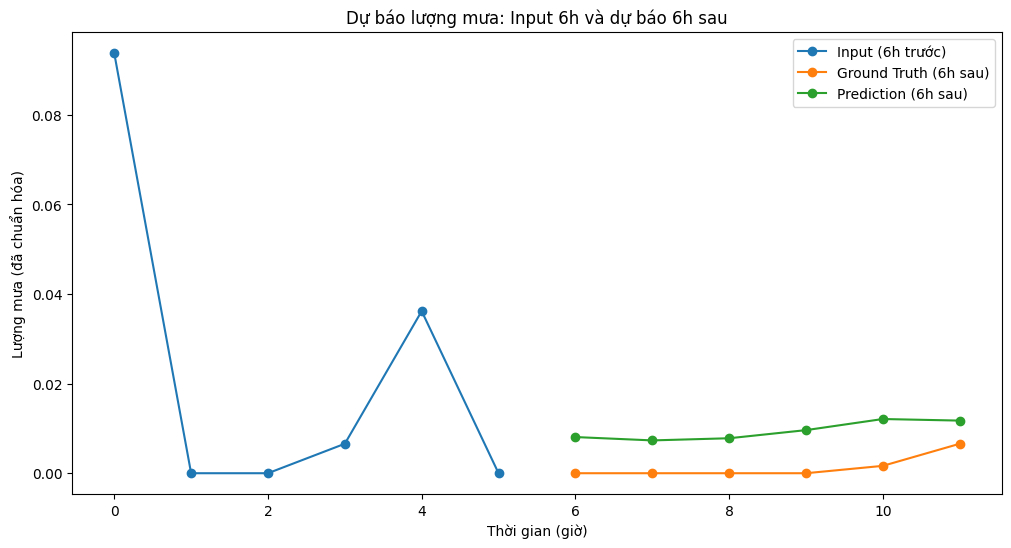

In [13]:
# Chọn một mẫu ngẫu nhiên từ tập test
sample_index = np.random.randint(0, X_test.shape[0])
input_sequence = X_test[sample_index].flatten()
ground_truth = y_test[sample_index].flatten()
prediction = y_pred[sample_index].flatten()

plt.figure(figsize=(12,6))
# Vẽ chuỗi input (6 giờ trước) – đặt ở các thời điểm 0-5
plt.plot(range(0, input_steps), input_sequence, marker='o', label='Input (6h trước)')
# Vẽ chuỗi ground truth (6 giờ sau) – đặt ở các thời điểm 6-11
plt.plot(range(input_steps, input_steps+output_steps), ground_truth, marker='o', label='Ground Truth (6h sau)')
# Vẽ chuỗi dự báo
plt.plot(range(input_steps, input_steps+output_steps), prediction, marker='o', label='Prediction (6h sau)')
plt.xlabel("Thời gian (giờ)")
plt.ylabel("Lượng mưa (đã chuẩn hóa)")
plt.title("Dự báo lượng mưa: Input 6h và dự báo 6h sau")
plt.legend()
plt.show()


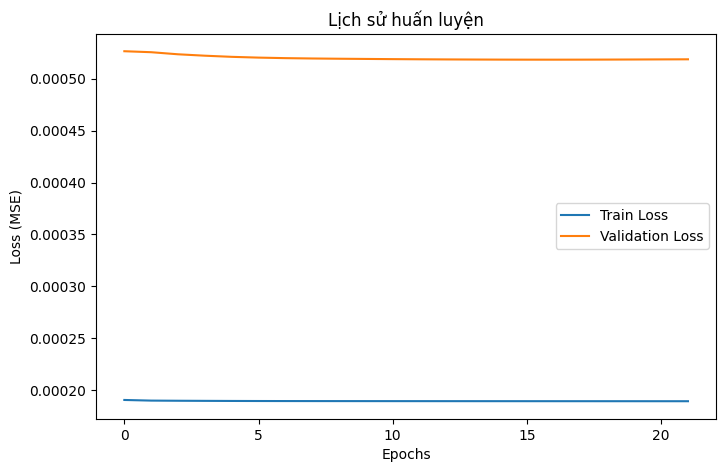

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Lịch sử huấn luyện")
plt.legend()
plt.show()
